# Object Encoder
This code shows the effectiveness of the object encoder.<br>
It finds the nearest objects of the query object among ~5000 candidate objects.<Br>

In [1]:
import os
project_dir = os.getcwd()
project_dir = "/".join(project_dir.split("/")[:-1])
os.chdir(project_dir)
print(project_dir)

/home/blackfoot/codes/TSGM


In [2]:
import torch
import torch.nn as nn
from model.Graph.resnet_obj import resnet18 as resnet18_obj
from utils.habitat_settings import default_sim_settings, make_cfg
import habitat, habitat_sim, quaternion, time, cv2, imageio, pickle, csv, skimage, joblib
import matplotlib.pyplot as plt
from magnum import Quaternion, Vector3, Rad
import quaternion as q
import numpy as np
import magnum as mn
import matplotlib.pyplot as plt
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from tqdm import tqdm
from PIL import Image, ImageFilter
from habitat_sim.utils.common import d3_40_colors_rgb
from utils.statics import CATEGORIES, COI_INDEX, DETECTION_CATEGORIES
import pandas as pd
import random
import torchvision.datasets as datasets
import torch.utils.data as data
import matplotlib.pyplot as plt
import joblib, glob, os, cv2
habitat_path = habitat.__path__[0]

In [3]:
feature_dim = 32
object_encoder = resnet18_obj(num_classes=feature_dim)
dim_mlp = object_encoder.fc.weight.shape[1]
object_encoder.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), object_encoder.fc)
ckpt_pth = os.path.join(project_dir, 'data/graph', 'Obj_encoder.pth.tar')
ckpt = torch.load(ckpt_pth, map_location='cpu')
state_dict = {k[len('module.encoder_k.'):]: v for k, v in ckpt['state_dict'].items() if 'module.encoder_k.' in k}
object_encoder.load_state_dict(state_dict)
object_encoder.eval().cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
settings = default_sim_settings.copy()
settings["max_frames"] = 100
settings["width"] = 256
settings["height"] = 256
settings["scene"] = ''
settings["save_png"] = False  # args.save_png
settings["sensor_height"] = 0.88
settings["color_sensor"] = True
settings["semantic_sensor"] = True
settings["depth_sensor"] = True
settings["print_semantic_scene"] = False
settings["print_semantic_mask_stats"] = False
settings["compute_shortest_path"] = False
settings["compute_action_shortest_path"] = False
settings["panoramic_sensor"] = True
settings["seed"] = 2343
settings["silent"] = False
settings["enable_physics"] = True
settings["draw_lidar"] = False
settings["agent_radius"] = 0.1
settings["agent_height"] = 1.2
settings["multiview"] = False
settings["hfov"] = 90
settings["FORWARD_STEP_SIZE"] = 0.25
settings["TURN_ANGLE"] = 10
settings["tdv_height"] = 512
settings["tdv_width"] = 512
settings["allow_sliding"] = True
num_of_camera = 12
pano_img_height = settings["height"]//2
img_height = pano_img_height
img_width = float(img_height * 4)
cam_width = float(pano_img_height * 4 // num_of_camera)
settings["cam_width"] = cam_width
settings["pano_height"] = pano_img_height

I1013 14:11:43.237296 1372292 simulator.py:221] Loaded navmesh /home/blackfoot/programs/habitat-lab-021/habitat/../data/scene_datasets/gibson_tiny/Allensville.navmesh
I1013 14:11:38.184828 1372292 ManagedFileBasedContainer.h:210] <Dataset>::convertFilenameToPassedExt : Filename : default changed to proposed scene_dataset_config.json filename : default.scene_dataset_config.json
I1013 14:11:38.184857 1372292 AttributesManagerBase.h:365] <Dataset>::createFromJsonOrDefaultInternal : Proposing JSON name : default.scene_dataset_config.json from original name : default | This file  does not exist.
I1013 14:11:38.184926 1372292 AssetAttributesManager.cpp:120] Asset attributes (capsule3DSolid : capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
I1013 14:11:38.184958 1372292 AssetAttributesManager.cpp:120] Asset attributes (capsule3DWireframe : capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and re

sim_cfg.physics_config_file = ./data/default.physics_config.json
Renderer: NVIDIA GeForce GTX TITAN X/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.54
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits
scan_name:  Allensville
floor:  0
lower_bound:  [-1.001614   -0.02151728 -7.8464866 

Tangents_false_capEnd_true) created and registered.
I1013 14:11:38.185010 1372292 AssetAttributesManager.cpp:120] Asset attributes (coneWireframe : coneWireframe_segments_32_halfLen_1.25) created and registered.
I1013 14:11:38.185020 1372292 AssetAttributesManager.cpp:120] Asset attributes (cubeSolid : cubeSolid) created and registered.
I1013 14:11:38.185029 1372292 AssetAttributesManager.cpp:120] Asset attributes (cubeWireframe : cubeWireframe) created and registered.
I1013 14:11:38.185053 1372292 AssetAttributesManager.cpp:120] Asset attributes (cylinderSolid : cylinderSolid_rings_1_segments_12_halfLen_1_useTexCoords_false_useTangents_false_capEnds_true) created and registered.
I1013 14:11:38.185073 1372292 AssetAttributesManager.cpp:120] Asset attributes (cylinderWireframe : cylinderWireframe_rings_1_segments_32_halfLen_1) created and registered.
I1013 14:11:38.185086 1372292 AssetAttributesManager.cpp:120] Asset attributes (icosphereSolid : icosphereSolid_subdivs_1) created and reg

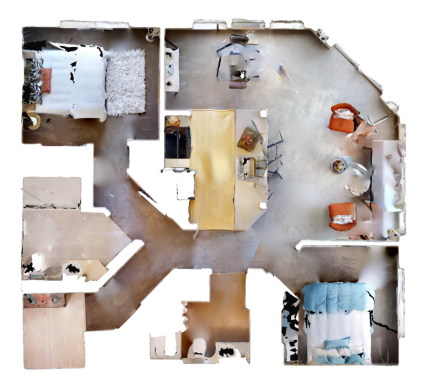

In [5]:
dataset = 'gibson_tiny'
scan_name = "Allensville"
render_configs = joblib.load(os.path.join(project_dir, f"data/floorplans/{dataset}_floorplans/render_config.pkl"))
settings["scene"] = os.path.join(habitat_path, '../data/scene_datasets/{}/{}.glb'.format(dataset, scan_name))

try:
    sim.close()
except:
    pass

cfg = make_cfg(settings)
sim = habitat_sim.Simulator(cfg)
    
max_object = 10
bounds = sim.pathfinder.get_bounds()
scene_objects = sim.semantic_scene.objects
if dataset == "mp3d":
    mapping = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene_objects if obj != None}
elif dataset == "hm3d":
    mapping = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene_objects if obj != None}
else:
    mapping = {int(obj.id.split("_")[-1]): int(np.where([obj.category.name() == cat for cat in CATEGORIES['gibson']])[0][0]) for obj in scene_objects if obj != None}

set_floor = 0
floor = -1
num_try = 0
while floor != set_floor:
    init_position = sim.pathfinder.get_random_navigable_point()
    floor =  int(np.argmin([abs(float(render_configs[scan_name][i]['z_low']) - init_position[1]) for i in render_configs[scan_name].keys()]))
    num_try += 1
    if num_try > 100:
        print("Cannot find a valid position")
        break
init_rotation = sim.get_agent(0).get_state().rotation.components
scene_file = settings["scene"]

sim.reset()
agent = sim.initialize_agent(0)
start_state = agent.get_state()
if (start_state.position != init_position).any():
    start_state.position = init_position
    start_state.rotation = q.from_float_array(init_rotation)  # self.init_rotation #
    start_state.sensor_states = dict()  ## Initialize sensori
agent.set_state(start_state)
prev_position = agent.get_state().position
prev_rotation = q.as_euler_angles(agent.state.rotation)[1]

P = render_configs[scan_name][floor]['Projection']
lower_bound, upper_bound = sim.pathfinder.get_bounds()
imgWidth = round(float(render_configs[scan_name][floor]['width']))
imgHeight = round(float(render_configs[scan_name][floor]['height']))
world_min_width = float(render_configs[scan_name][floor]['x_low'])
world_max_width = float(render_configs[scan_name][floor]['x_high'])
world_min_height = float(render_configs[scan_name][floor]['y_low'])
world_max_height = float(render_configs[scan_name][floor]['y_high'])
worldWidth = abs(world_min_width) + abs(world_max_width)
worldHeight = abs(world_min_height) + abs(world_max_height)

print('====================================')
print('scan_name: ', scan_name)
print('floor: ', floor)
print('lower_bound: ', lower_bound)
print('upper_bound: ', upper_bound)
print('imgWidth: ', imgWidth)
print('imgHeight: ', imgHeight)


ortho_map = cv2.imread(os.path.join(project_dir, f"data/floorplans/{dataset}_floorplans/rgb/{scan_name}_level_{floor}.png"))[...,::-1][...,:3]
ortho_mask = cv2.imread(os.path.join(project_dir, f"data/floorplans/{dataset}_floorplans/mask/{scan_name}_level_{floor}.png"), 0)
ortho_map[ortho_mask==0] = 255
plt.axis("off")
plt.imshow(ortho_map)

In [6]:
def to_grid(realworld_x: float,realworld_y: float,):
    A = [realworld_x-(worldWidth+2*world_min_width)/2, realworld_y-(worldHeight+2*world_min_height)/2, 1, 1]
    grid_x, grid_y = np.array([imgWidth/2, imgHeight/2]) * np.matmul(P, A)[:2] + np.array([imgWidth/2, imgHeight/2])
    return int(grid_x), int(grid_y)

def from_grid(grid_x: int,grid_y: int):
    realworld_x, realworld_y = np.matmul(np.linalg.inv(P), [(2 * grid_x - imgWidth)/imgWidth, (2 * grid_y - imgHeight)/imgHeight, 1, 1])[:2] \
                               + np.array([(worldWidth+2*world_min_width)/2, (worldHeight+2*world_min_height)/2])
    return realworld_x, realworld_y
from habitat.utils.geometry_utils import (
    quaternion_from_coeff,
    quaternion_rotate_vector,
)
from habitat.tasks.utils import cartesian_to_polar
def get_map_angle(ref_rotation):
    heading_vector = quaternion_rotate_vector(
        ref_rotation.inverse(), np.array([0, 0, -1])
    )

    phi = cartesian_to_polar(-heading_vector[2], heading_vector[0])[1]
    return np.array(phi)

In [7]:
init_position = sim.pathfinder.get_random_navigable_point()
init_rotation = sim.get_agent(0).get_state().rotation.components
scene_file = settings["scene"]

sim.reset()
agent = sim.initialize_agent(0)
start_state = agent.get_state()
if (start_state.position != init_position).any():
    start_state.position = init_position
    start_state.rotation = q.from_float_array(init_rotation)  # self.init_rotation #
    start_state.sensor_states = dict()  ## Initialize sensori
agent.set_state(start_state)
prev_position = agent.get_state().position
prev_rotation = q.as_euler_angles(agent.state.rotation)[1]

In [8]:
scene_objects = sim.semantic_scene.objects
mapping = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene_objects if obj != None}
object_loc = {int(obj.id.split("_")[-1]): obj.aabb.center for obj in scene_objects if obj != None}

In [9]:
def get_objects(semantic, mapping, depth, img_width, img_height):
    semantic = semantic.astype(np.int32)
    max_key = np.max(np.array(list(mapping.keys())))
    replace_values = []
    for i in np.arange(max_key + 1):
        try:
            replace_values.append(mapping[i])
        except:
            replace_values.append(-1)
    semantic_obs_class = np.take(replace_values, semantic)
    COI_MASK = [(semantic_obs_class == ci).astype(np.int32) for ci in COI_INDEX[dataset.split("_")[0]]]  # class mask
    unique_instances = np.unique(semantic * np.sum(np.stack(COI_MASK), 0))[1:]
    bbox_ids = unique_instances
    instance_segment = [(semantic == i).astype(np.int32) for i in unique_instances]
    box_categories = [np.unique(semantic_obs_class[semantic == i])[0] for i in unique_instances]
    if len(instance_segment) > 0:
        object_size = np.stack([np.sum(instance_segman) for instance_segman in instance_segment])
        mask = (object_size > 100)
        instance_segment = [instance_segman for i, instance_segman in enumerate(instance_segment) if mask[i] == 1]
        box_categories = np.stack(box_categories)[mask == 1]
        bbox_ids = np.array(bbox_ids)[mask == 1]

    x1s = [np.min(np.where(instance_segment[i])[1]) for i in range(len(instance_segment))]
    y1s = [np.min(np.where(instance_segment[i])[0]) for i in range(len(instance_segment))]
    x2s = [np.max(np.where(instance_segment[i])[1]) for i in range(len(instance_segment))]
    y2s = [np.max(np.where(instance_segment[i])[0]) for i in range(len(instance_segment))]
    bboxes = np.stack((x1s, y1s, x2s, y2s), 1)
    if len(bboxes) > 0:
        edge_box_idx = np.where(bboxes[:, 2] - bboxes[:, 0] > img_width * 0.8)[0]
        not_edge_box_idx = np.where(bboxes[:, 2] - bboxes[:, 0] <= img_width * 0.8)[0]
        if len(edge_box_idx) > 0:
            x1s1 = [np.min(np.where(instance_segment[i][:, :int(instance_segment[i].shape[1] / 2)])[1]) for i in edge_box_idx]
            y1s1 = [np.min(np.where(instance_segment[i][:, :int(instance_segment[i].shape[1] / 2)])[0]) for i in edge_box_idx]
            x2s1 = [np.max(np.where(instance_segment[i][:, :int(instance_segment[i].shape[1] / 2)])[1]) for i in edge_box_idx]
            y2s1 = [np.max(np.where(instance_segment[i][:, :int(instance_segment[i].shape[1] / 2)])[0]) for i in edge_box_idx]
            bboxes_1 = np.stack((x1s1, y1s1, x2s1, y2s1), 1)
            bboxes_1_categories = box_categories[edge_box_idx]
            bboxes_1_ids = bbox_ids[edge_box_idx]
            x1s2 = [int(instance_segment[i].shape[1] / 2) + np.min(np.where(instance_segment[i][:, int(instance_segment[i].shape[1] / 2):])[1]) for i in edge_box_idx]
            y1s2 = [np.min(np.where(instance_segment[i][:, int(instance_segment[i].shape[1] / 2):])[0]) for i in edge_box_idx]
            x2s2 = [int(instance_segment[i].shape[1] / 2) + np.max(np.where(instance_segment[i][:, int(instance_segment[i].shape[1] / 2):])[1]) for i in edge_box_idx]
            y2s2 = [np.max(np.where(instance_segment[i][:, int(instance_segment[i].shape[1] / 2):])[0]) for i in edge_box_idx]
            bboxes_2 = np.stack((x1s2, y1s2, x2s2, y2s2), 1)
            bboxes_2_categories = box_categories[edge_box_idx]
            bboxes_2_ids = bbox_ids[edge_box_idx]
            bboxes_ = bboxes[not_edge_box_idx]
            box_categories_ = box_categories[not_edge_box_idx]
            bbox_ids_ = bbox_ids[not_edge_box_idx]
            bboxes = np.concatenate((bboxes_, bboxes_1, bboxes_2), 0)
            box_categories = np.concatenate((box_categories_, bboxes_1_categories, bboxes_2_categories), 0)
            bbox_ids = np.concatenate((bbox_ids_, bboxes_1_ids, bboxes_2_ids), 0)

    if len(depth) > 0 and len(bboxes) > 0:
        box_pix_xs, box_pix_ys = ((bboxes[:, 0])).astype(np.int32), ((bboxes[:, 1])).astype(np.int32)
        box_depth = np.stack([depth[box_pix_y, box_pix_x] for box_pix_x, box_pix_y in zip(box_pix_xs, box_pix_ys)])
        box_mask = box_depth < 5
        if np.sum(box_mask) == 0:
            return [], [], [], [], []
        bboxes = bboxes[box_mask]
        box_categories = box_categories[box_mask]
        bbox_ids = bbox_ids[box_mask]
        box_depth = box_depth[box_mask]
        box_world = np.stack([object_loc[bbox_id] for bbox_id in bbox_ids])

        bboxes = bboxes.astype(np.float32)
        bboxes[:, 0] = bboxes[:, 0].astype(np.float32) / float(img_width)
        bboxes[:, 1] = bboxes[:, 1].astype(np.float32) / float(img_height)
        bboxes[:, 2] = bboxes[:, 2].astype(np.float32) / float(img_width)
        bboxes[:, 3] = bboxes[:, 3].astype(np.float32) / float(img_height)
        return bboxes, box_categories, bbox_ids, box_depth, box_world
    return [], [], [], [], []

In [10]:
import torchvision.transforms as transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
eval_augmentation = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])

In [11]:
def draw_bbox(rgb: np.ndarray, bboxes: np.ndarray, color = (178,193,118), is_detection=False) -> np.ndarray:
    for i, bbox in enumerate(bboxes):
        imgHeight, imgWidth, _ = rgb.shape
        cv2.rectangle(rgb, (int(bbox[0]*imgWidth), int(bbox[1]*imgHeight)), (int(bbox[2]*imgWidth), int(bbox[3]*imgHeight)), (255, 255, 0), 5)
    return rgb

# Set a query object

/home/blackfoot/anaconda3/envs/habitat021/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


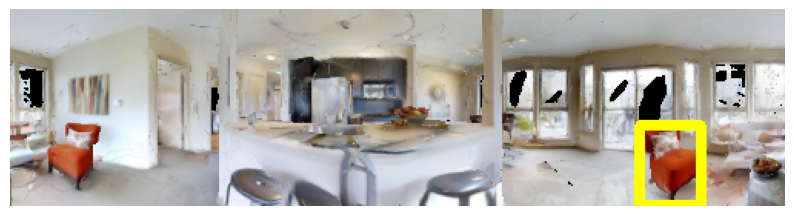

In [12]:
ref_position = Vector3([ 5.7568417,   0.17848273, -4.318102  ])
ref_rotation = q.from_float_array([0.718560431643838, 0, 0.695464525389916, 0])
state = agent.get_state()
state.position = ref_position
state.rotation = ref_rotation
agent.set_state(state)
obs = sim.get_sensor_observations()
rgb = np.concatenate([obs['panoramic_rgb_part_sensor_%d' % (i)][:, :, :3] for i in range(num_of_camera)], 1)
image = eval_augmentation(Image.fromarray(rgb.astype(np.uint8)))
image = image[None].cuda()
ref_bbox = [[0.81349206, 0.5859375,  0.89285713, 0.9921875 ]]
ref_feat = object_encoder(image, torch.tensor(np.concatenate((np.zeros([len(ref_bbox), 1]), ref_bbox), -1)).cuda()[None].float())[0]
ref_norm = nn.functional.normalize(torch.tensor(ref_feat).cuda(), dim=-1)

ref_img = draw_bbox(rgb.copy(), ref_bbox) 
fig = plt.figure(figsize=(10,5))
plt.axis("off")
plt.imshow(ref_img)

# Collect candidates

In [13]:
env_feats = []
env_images = []
env_bboxes = []
for i in tqdm(range(1000)):
    position = sim.pathfinder.get_random_navigable_point()
    random_angle = np.random.rand() * 2 * np.pi
    rotation = q.from_rotation_vector([0, random_angle, 0])
    state = agent.get_state()
    state.position = position
    state.rotation = rotation
    state.sensor_states = dict()
    agent.set_state(state)
    obs = sim.get_sensor_observations()
    
    rgb = np.concatenate([obs['panoramic_rgb_part_sensor_%d' % (i)][:, :, :3] for i in range(num_of_camera)], 1)
    semantic_array = np.concatenate([obs['panoramic_semantic_part_sensor_%d' % (i)] for i in range(num_of_camera)], 1)
    depth_array = np.concatenate([obs['panoramic_depth_part_sensor_%d' % (i)] for i in range(num_of_camera)], 1)
    bboxes, bbox_categories, bbox_ids, bbox_depth, bbox_pose = get_objects(semantic_array, mapping, depth_array, rgb.shape[1], rgb.shape[0])
    image = eval_augmentation(Image.fromarray(rgb.astype(np.uint8)))
    image = image[None].cuda()    
    
    env_images.append(rgb)
    if len(bboxes)>0:
        feat = object_encoder(image, torch.tensor(np.concatenate((np.zeros([len(bboxes), 1]), bboxes), -1)).cuda()[None].float())[0]
        bboxes = np.concatenate((np.ones([len(bboxes), 1])*i, bboxes), -1)
        env_bboxes.extend(bboxes)
        env_feats.extend(feat.cpu().detach().numpy())
env_images = np.stack(env_images)
env_feats_norm = nn.functional.normalize(torch.tensor(np.stack(env_feats)).cuda(), dim=-1)
print(f"Total {len(env_bboxes)} Candidates")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.64it/s]


Total 4734 Candidates


# Visualize top 10 objects

0.9989588


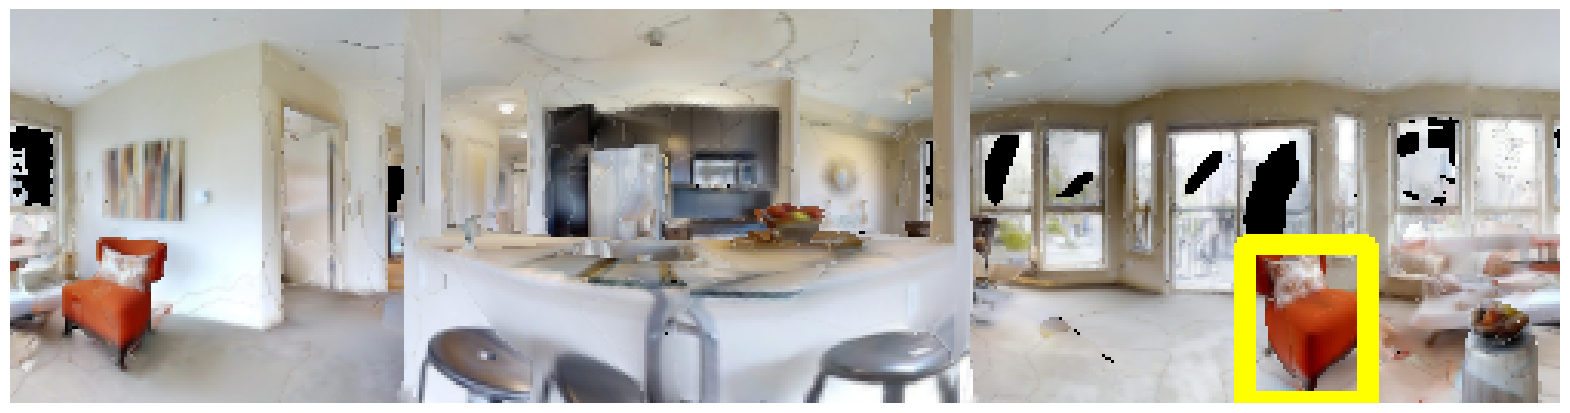

0.9977113


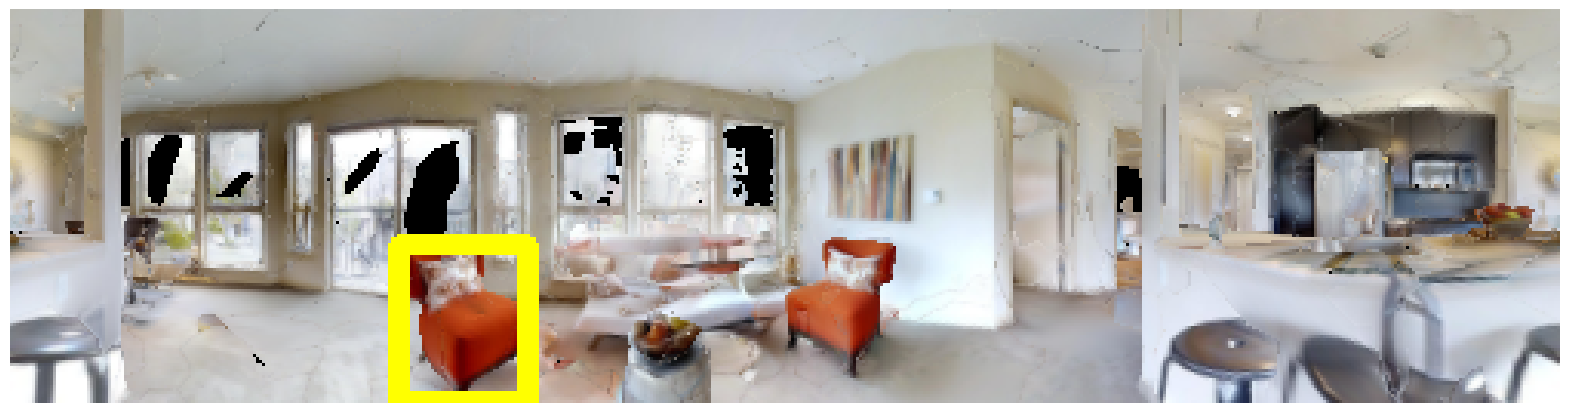

0.9956635


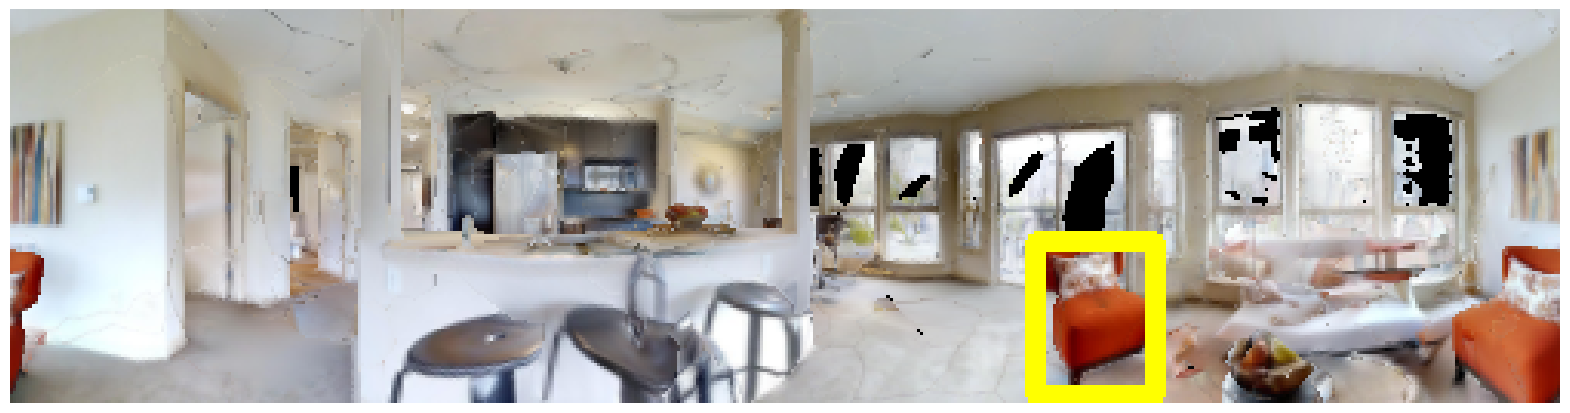

0.99528503


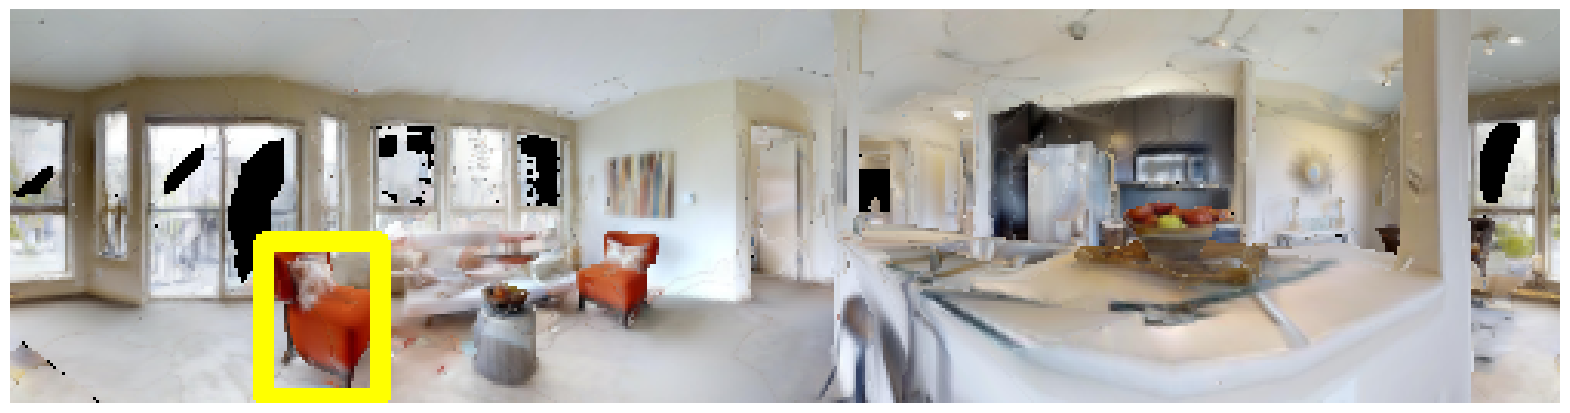

0.99370223


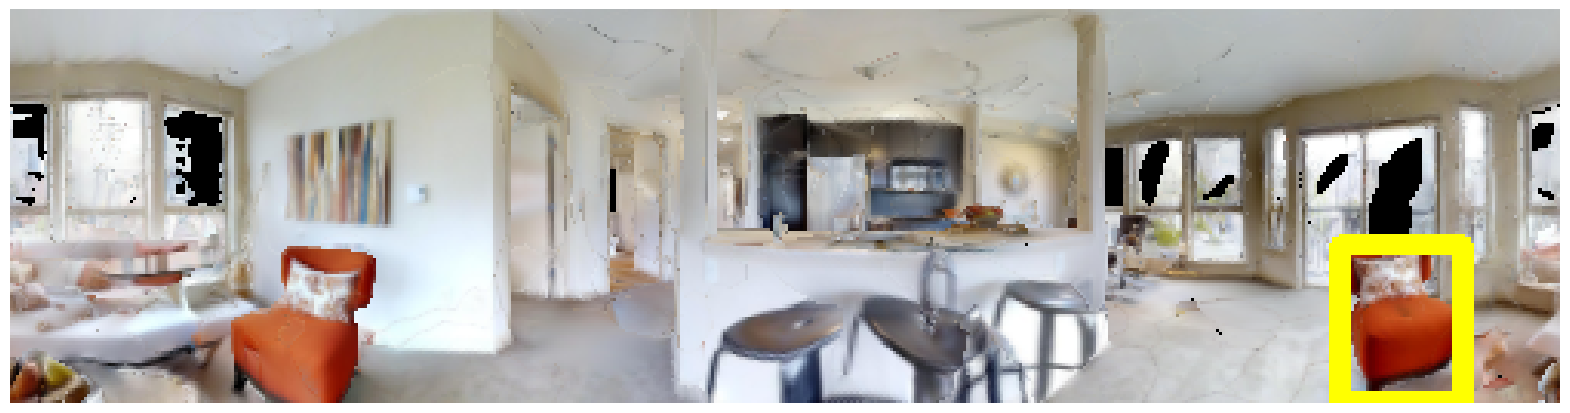

0.99234855


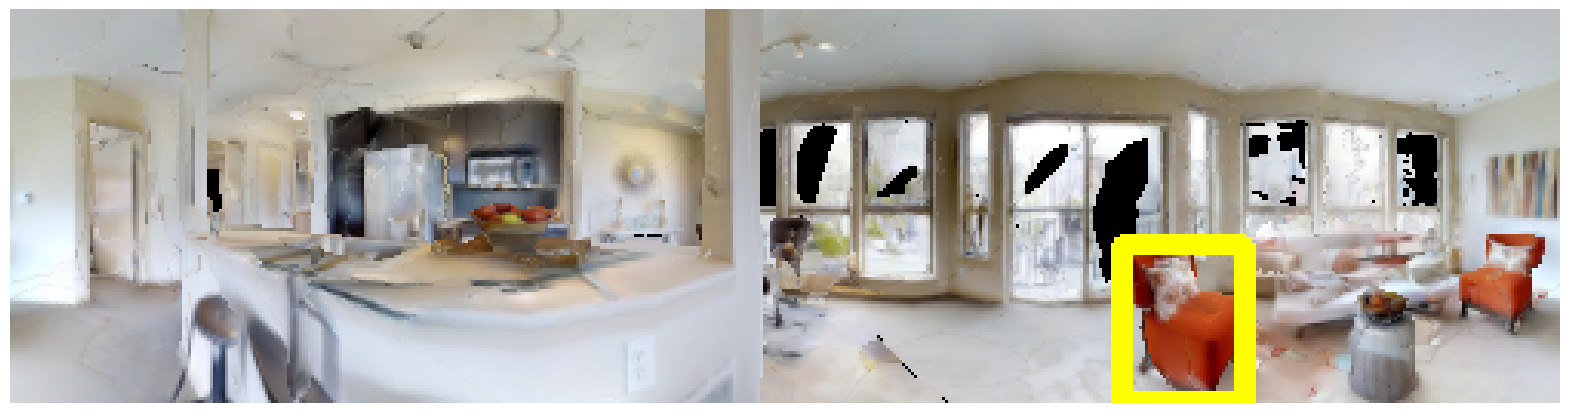

0.9907376


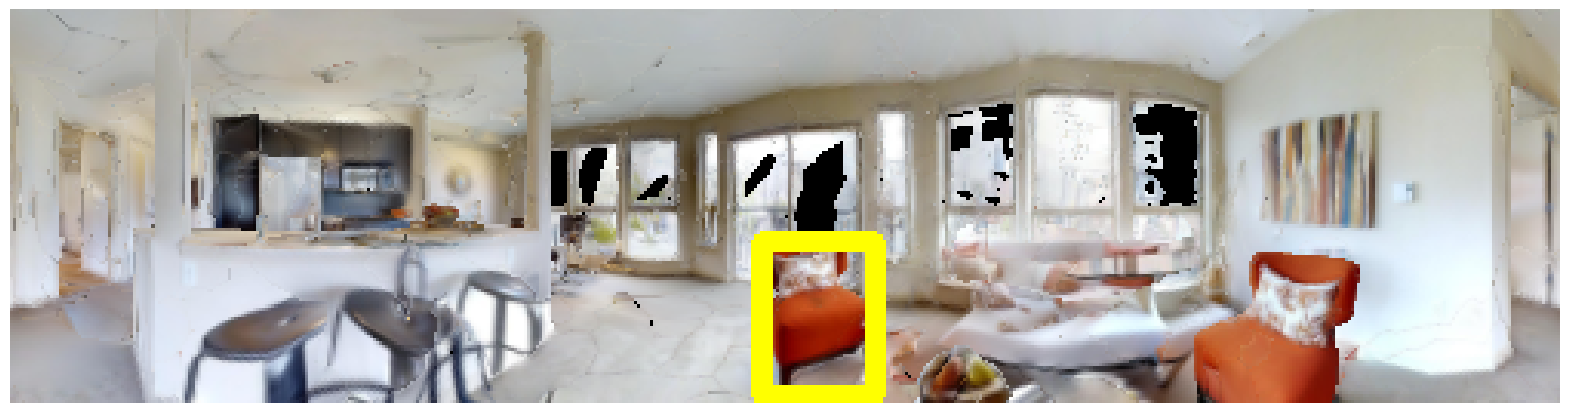

0.9902466


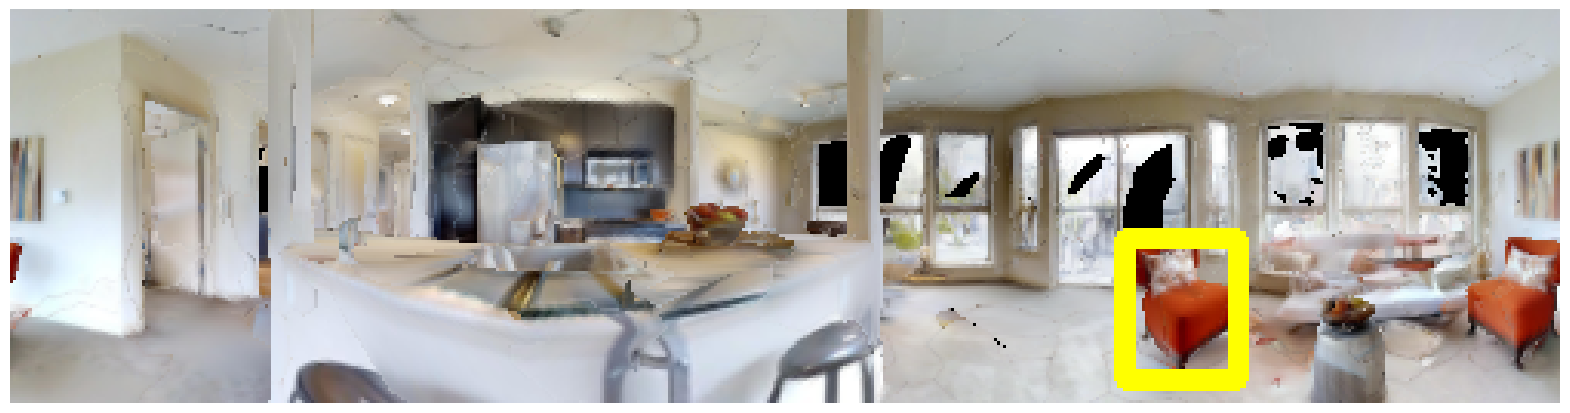

0.98836374


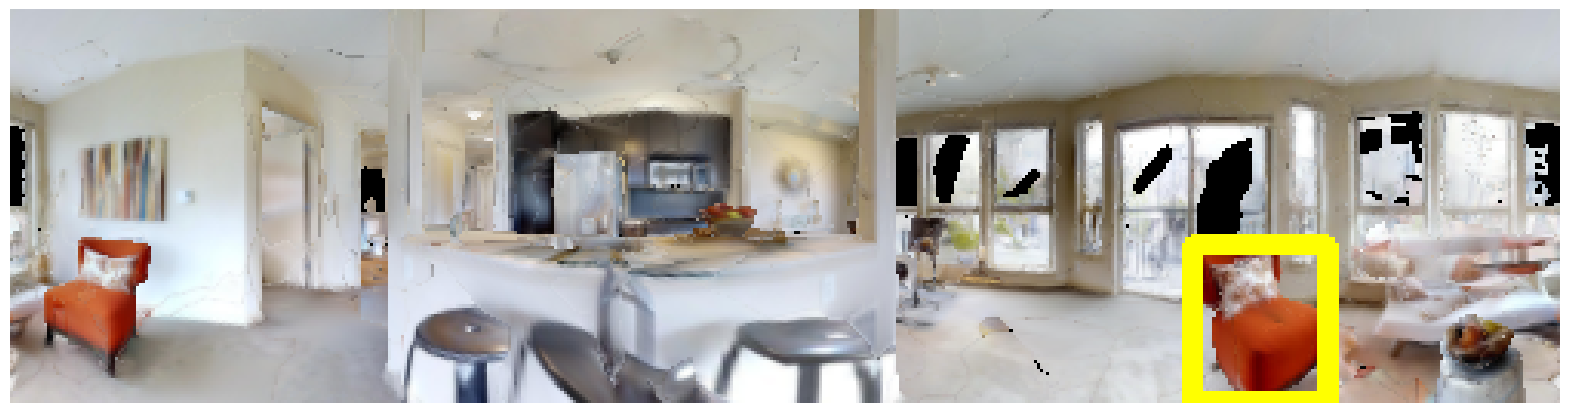

0.98811126


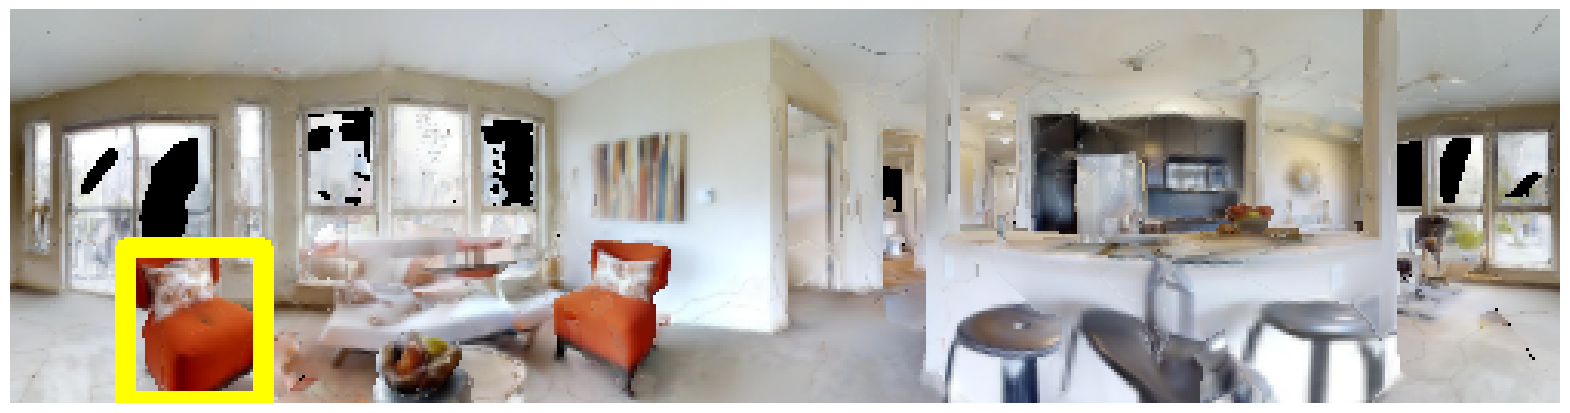

In [14]:
logits = torch.matmul(ref_norm, env_feats_norm.transpose(1,0)).cpu().detach().numpy()[0]
top_index = (-logits).argsort()[:10]
img_index = np.stack(env_bboxes)[:, 0]
imgs = []
for idx in top_index:
    max_img = env_images[int(img_index[idx])]
    bbox_a = env_bboxes[idx]
    max_img = draw_bbox(max_img.copy(), bbox_a[1:][None])
    imgs.append(max_img)
    fig = plt.figure(figsize=(20,20))
    plt.imshow(max_img)
    print(logits[idx])
    plt.axis("off")
    plt.show()